# Event separation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial
import seaborn as sns
import calendar

In [ ]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 2
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']

df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')


In [67]:
events_pd = np.zeros(len(df[value_column]))
time_limit = 6*24
in_index = False
time_count = 0
event_count = 1
index = 0

for i, p in enumerate(df[value_column]):
    if p != 0:
        time_count = 0
        if in_index == False:
            in_index = True
            index = i            
    if p == 0:
        time_count += 1
        if time_count >= time_limit and in_index == True:
            in_index = False
            events_pd[index:i-time_limit+1] = event_count
            event_count += 1

df['events'] = events_pd

In [ ]:
events_sum = df.groupby('events')[value_column].sum()
events_sum_pd = np.zeros(shape=[len(df[value_column])])
for i, e in enumerate(df['events']):
    events_sum_pd[i] = events_sum[int(e)]
df['events_sum'] = events_sum_pd

[[Timestamp('1981-01-01 00:00:00') 0.0 0.0]
 [Timestamp('1981-01-01 00:10:00') 0.0 0.0]
 [Timestamp('1981-01-01 00:20:00') 0.0 0.0]
 ...
 [Timestamp('2024-12-31 23:30:00') 0.0 0.0]
 [Timestamp('2024-12-31 23:40:00') 0.0 0.0]
 [Timestamp('2024-12-31 23:50:00') 0.0 0.0]]


In [ ]:
start_times = df.groupby('events')['time'].min()
end_times = df.groupby('events')['time'].max()
durations = np.array((end_times - start_times).dt.total_seconds())/(60*60)
events = df.groupby('events')['events_sum'].first().values
durations = np.delete(durations,0)
events = np.delete(events,0)
start_times = np.delete(start_times,0)

['1981-01-02T06:30:00.000000000' '1981-01-06T04:40:00.000000000'
 '1981-01-07T22:30:00.000000000' ... '2024-12-14T12:40:00.000000000'
 '2024-12-19T06:20:00.000000000' '2024-12-21T19:40:00.000000000']


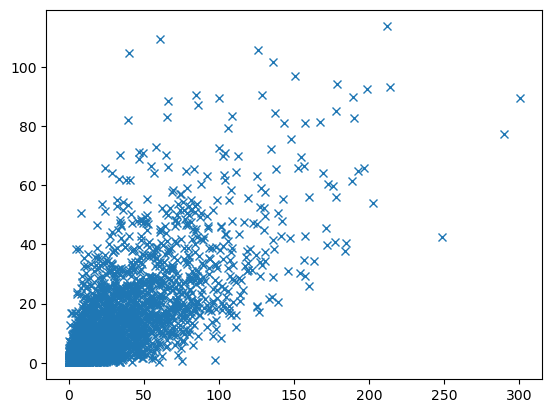

In [139]:
plt.plot(durations, events,'x')